# Encoding the Hubbard Hamiltonian 

This notebook shows how to use a Fermion-Qubit encoding to encode the second quantised Hubbard hamiltonian.

$$H_{Hubbard} = -t \sum_{\langle i,j \rangle,\sigma}(a^{\dagger}_{i,\sigma} a_{j, \sigma} + a^{\dagger}_{j, \sigma} a_{i,\sigma}) + U \sum_{i} \hat{n}_i \hat{n}_i$$

## Simple Useage

The Hubbard Hamiltonian needs two scaler coefficients, the kinetic term $t$ and the onsite-term $U$. 

We can either define both $t$ and $U$, or use the default $t=1$ and scale $U$ around it.

In [1]:
onsite_term = 2.
hopping_term = 0.5

We can now make an encoding for the size of system we want to look at, let's say 12 modes.

In [2]:
from ferrmion import TernaryTree
tt = TernaryTree(6)

To encode a hamiltonian, we need both a mapping from fermonic operators to qubits, and an enumeration scheme which accounts for the degrees of freedom when labeling modes and qubits.

For the mapping, we'll use JordanWigner and for the enumeration scheme, we can use the default one.

Note we can [optimise our encoded hamiltonian](https://ferrmion.readthedocs.io/en/latest/notebooks/pauli_weight.html) by getting more clever with these.

In [3]:
jw = tt.JW()
jw.enumeration_scheme = jw.default_enumeration_scheme()
jw.enumeration_scheme

{'': (0, 0),
 'z': (1, 1),
 'zz': (2, 2),
 'zzz': (3, 3),
 'zzzz': (4, 4),
 'zzzzz': (5, 5)}

In [4]:
from ferrmion.hamiltonians.hubbard import linear_adjacency_matrix
from ferrmion.hamiltonians import hubbard_hamiltonian
hamiltonian = hubbard_hamiltonian(encoding=jw,adjacency_matrix=linear_adjacency_matrix(jw.n_modes, periodic=False), onsite_term=onsite_term, hopping_term=hopping_term)
hamiltonian

{'IIYZYI': (0.25+0j),
 'IYZYII': (0.25+0j),
 'YZYIII': (0.25+0j),
 'IIIXZX': (0.25+0j),
 'IIZIII': (-1+0j),
 'IIIIII': (6+0j),
 'XZXIII': (0.25+0j),
 'IZIIII': (-1+0j),
 'IIIYZY': (0.25+0j),
 'IIIIZI': (-1+0j),
 'ZIIIII': (-1+0j),
 'IIIIIZ': (-1+0j),
 'IXZXII': (0.25+0j),
 'IIXZXI': (0.25+0j),
 'IIIZII': (-1+0j)}

## Hamiltonian Templates

Sometimes it can be useful to find out how an encoding behaves without providing coefficients. This lets us see which terms of the second quantised hamiltonian contribute to which pauli terms of the qubit Hamiltonian.

### Creating a Template

In [5]:
from ferrmion.hamiltonians import hubbard_hamiltonian_template

The only information we need to provide is a set of XZ-encoded vectors (this is how ferrmion manipulates encodings internally) and imaginary factors for these vectors. 

In [6]:
ipowers, symplectics = jw._build_symplectic_matrix()

In [7]:
ipowers

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=uint8)

In [8]:
import numpy as np
np.array(symplectics, dtype=int)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])

In [9]:
template = hubbard_hamiltonian_template(ipowers, symplectics)
first_key = [*template.keys()][0]
first_key, template[first_key]

('XZZZZX', {(0, 5): (0.25+0j), (5, 0): (0.25+0j)})

### Filling a Template

So we can now see which modes contribute to each Pauli operator.

To fill a template, we need to provide the one and two electron coefficients for the Hamiltonian. For the Hubbard Hamiltonian, these follow from the onsite and hopping terms.

We also provide a matrix describing which lattice sites are adjacent. For a linear system it, we need sites $(i,i+1)$ $\forall i \in 0,...,M-1 $ to be adjacent.

In [10]:
import matplotlib.pyplot as plt
from ferrmion.hamiltonians.hubbard import hubbard_coefficients

n_modes = jw.n_modes
adjacency_matrix = np.eye(n_modes, k=1) + np.eye(n_modes, k=-1)
print(adjacency_matrix)

one_e_coeffs, two_e_coeffs = hubbard_coefficients(n_modes, adjacency_matrix, onsite_term, hopping_term)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


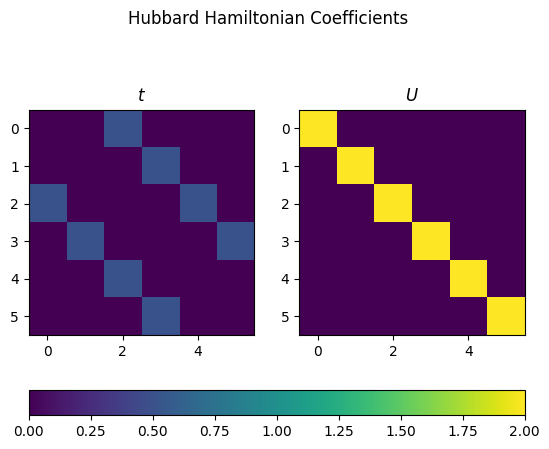

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
fig, axs = plt.subplots(1, 2)
fig.suptitle('Hubbard Hamiltonian Coefficients')
# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min(0), vmax=np.max([onsite_term, hopping_term]))

axs[0].set_title("$t$")
axs[1].set_title("$U$")
images = []
images.append(axs[0].imshow(one_e_coeffs, norm=norm))
# We use einsum to see the values for number operators
images.append(axs[1].imshow(np.einsum("iijj->ij", two_e_coeffs), norm=norm))
fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)
plt.show()



We also need to provide a mapping from fermionic modes to majorana operators. Again we can use the default.

In [12]:
jw.default_mode_op_map

array([0, 1, 2, 3, 4, 5], dtype=uint64)

For the Hubbard Hamiltonian, there is o constant energy term, so we can set this to 0.

In [13]:
from ferrmion.hamiltonians import fill_template
filled_template = fill_template(template,constant_energy=0, one_e_coeffs=one_e_coeffs, two_e_coeffs=two_e_coeffs, mode_op_map=jw.default_mode_op_map)
filled_template

{'ZIIIII': (-1+0j),
 'YZYIII': (0.25+0j),
 'IIIXZX': (0.25+0j),
 'IIXZXI': (0.25+0j),
 'IIYZYI': (0.25+0j),
 'IIIYZY': (0.25+0j),
 'IZIIII': (-1+0j),
 'IIIIII': (6+0j),
 'IIZIII': (-1+0j),
 'IIIIZI': (-1+0j),
 'IYZYII': (0.25+0j),
 'XZXIII': (0.25+0j),
 'IIIIIZ': (-1+0j),
 'IXZXII': (0.25+0j),
 'IIIZII': (-1+0j)}

Let' check to see that we have the same hamiltonian in each.

In [14]:
assert hamiltonian.keys() == filled_template.keys()
for k in hamiltonian.keys():
    # There is a little numerical instability so 
    # some values are different by 1e-18 or so!
    assert np.isclose(hamiltonian[k], filled_template[k])